In [1]:
#LOAD MODULES
import os
import glob
import sys
from tqdm import tqdm_notebook as tqdm
from random import randint
import matplotlib
import numpy as np
import pickle
import tensorflow as tf

from scipy import misc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

After completing the One of the first things that I wondered about when carrying out this project was how to obtain the masks for training the 

The dron has 4 cameras with different views/ranges:
    1. World 
    2. People
    3. Camera
    4. Depth

The files are labeled as follow for one of the four cameras  "cam( number )_( 5 digits number )"

With a simple script we can extract and visualize the different camera views

In [41]:
#Load all images from selected folder in a sorted list with the 4 camera views
print(os.getcwd())
folder = '../data/raw_sim_data/train/run3/on_target/'

def img_to_list(folder, image_type):
    img_list = glob.glob(folder +'*.' + str(image_type))
    return img_list

images =sorted(img_to_list(folder, 'png'))

steps = int(len(images)/4)
dron_images_list = []
for i in range(0,steps):
    cameras_pick = []
    for j in range(0,4):
        cameras_pick.append(images[i+j*steps])
    dron_images_list.append(cameras_pick)


D:\Projects\RoboND-DeepLearning-Project\code


In [42]:
def plot_images_together(ran_images):
    #generate a border for between images
    border = np.zeros((ran_images[0].shape[0],10,3))
    img_concat = np.concatenate((ran_images[0],border),axis=1)
    for i in ran_images[1:]:
        img_concat = np.concatenate((img_concat,border,i),axis=1)

    plt.figure(figsize=(10,5))
    plt.imshow(img_concat)
    plt.show()

In [43]:
# with this information we can create the mask for training our algorithms
# As is developed in this project we need to generate a RGB image with:
#   BLUE channel = pixel from the image one
def mask_img(imag):
    imag = imag.copy()
    imag[imag==1] = 0
    imag[imag!=0] = 1
    return imag


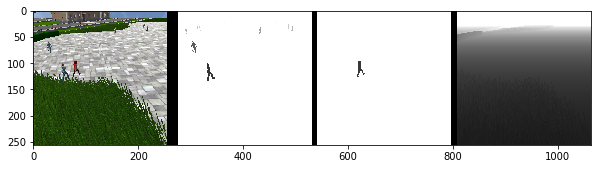

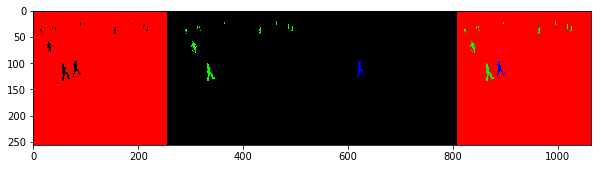

NameError: name 'image_stats' is not defined

In [85]:
# Select a random number and load the pictures for visualization
it = randint(0,steps)
ran_images = [np.array(mpimg.imread(img)) for img in dron_images_list[it]]
plot_images_together(ran_images)
#Visualization of masks creation
#new imag with all zeros from the shape of the original images
img = np.zeros(ran_images[1].shape)
#get the simulator images and build the masks
people = mask_img(ran_images[1].copy())
hero = mask_img(ran_images[2].copy())
no_world = people + hero
mask = (no_world[:,:,0] == 0)
#blend mask together (world,people,hero)
img[:,:,0][mask] = 1
img[:,:,1] = people[:,:,0]
img[:,:,2] = hero[:,:,0]
#create isolated mask for visualization porpuses
red_mask = np.zeros(img.shape)
red_mask[:,:,0]=img[:,:,0]
green_mask = np.zeros(img.shape)
green_mask[:,:,1]=img[:,:,1]
blue_mask = np.zeros(img.shape)
blue_mask[:,:,2]=img[:,:,2]

#list images + channel mask
channels = []
channels.append(red_mask)
channels.append(green_mask)
channels.append(blue_mask)
channels.append(img)
plot_images_together(channels)

image_stats(ran_images[0])

#### Image Histrogram analysis

In [86]:
def compute_channels_hist(img,bins = 255, print_diagrams = False):
    
    bn = bins
    histograms = [np.histogram(analysis_img[:,:,i],bins = bn) for i in range(0,3)]
    histogram = histograms[0][0] + histograms[1][0] + histograms[2][0]
    
    if print_diagrams:
        plt.title('histograms')
        g_channel, = plt.plot(histograms[1][0], 'green')
        b_channel, = plt.plot(histograms[2][0], 'blue')
        r_channel, = plt.plot(histograms[0][0], 'red')
        plt.plot(histogram, 'black')
        plt.legend([r_channel,g_channel, b_channel], ['Red', 'Green', 'Blue'])
        plt.show()
    return histograms

[max,min,mean,standard deviation] =  [255, 0, 104.6325174967448, 67.64416575997079]

[1.0, -1.0, -0.17935280394709971, 0.5305424765487905]
-0.179352803947
0.530542476549


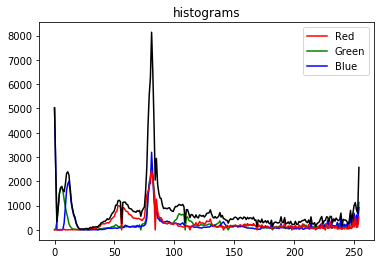

In [103]:
#from tkinter.filedialog import askopenfilename
#filename = askopenfilename()
from scipy import misc
filename = 'D:/Projects/RoboND-DeepLearning-Project/images/cam1_00002.png'
analysis_img = misc.imread(filename)
'''
it = randint(0,steps)

ran_images = [np.array(mpimg.imread(img)) for img in dron_images_list[it]]
analysis_img = ran_images[0]
'''

def preprocess_input(x):
    x = x/255.
    x = x-0.5
    x = x*2.
    return x

def image_stats(analysis_img):
    # compute stats for an image
    # input: an string containing the path of the image
    # output: stats = [max,min,mean,standard deviation]
    stats = []
    stats.append(np.amax(analysis_img))
    stats.append(np.amin(analysis_img))
    stats.append(np.mean(analysis_img))
    stats.append(np.std(analysis_img))
    return stats
print('[max,min,mean,standard deviation] = ',image_stats(analysis_img))
print()

analysis_img2 = preprocess_input(analysis_img)
print(image_stats(analysis_img2))
print(np.mean(analysis_img2))
print(np.std(analysis_img2))
histograms = compute_channels_hist(analysis_img, 255,True)

In [8]:
#Data for training analysis

#folders
train_folder = '../data/train/images/'
validation_folder = '../data/validation/images/'

#load paths 
train_images = sorted(img_to_list(train_folder, 'jpeg'))
validation_images =  sorted(img_to_list(validation_folder,'jpeg'))

#load images, comput stats and add to list [mean, standar deviation] 
train_means = []
train_stds = []


for it in tqdm(train_images):
    stats = image_stats(it)
    train_means.append(stats[2])
    train_stds.append(stats[3])

NameError: name 'image_stats' is not defined

In [88]:
print('train images = ',len(train_images))
print('validation images = ',len(validation_images))

train images =  5003
validation images =  1184


In [89]:
# SAVE THE STATS
if not save_stats:
    save_stats = []
    save_stats.append(train_means)
    save_stats.append(train_stds)
    with open('../train_stats.p', "wb" ) as file:
        pickle.dump( save_stats, file )

NameError: name 'save_stats' is not defined

In [2]:
# LOAD THE STATS 
save_stats = pickle.load(open('../train_stats.p', "rb" ))

In [4]:
print('mean = ',np.mean(save_stats[0]))
print('std mean = ',np.mean(save_stats[1]))
print(len(save_stats[0]))

mean =  97.4002531888
std mean =  63.1252946466
4131


In [5]:
print(4131-5003
     )

-872


### Input
- input layer size [None, 160, 160, 3]

### Encoder Blocks
- encod1 layer size [None, 80, 80, 32]
- encod2 layer size [None, 40, 40, 64]
- encod3 layer size [None, 20, 20, 128]
- encod4 layer size [None, 10, 10, 256]
- encod5 layer size [None, 5, 5, 512]

### 1x1 Convolution
- conv_layer layer size [None, 5, 5, 512]

### Decoder Blocks
- decoder1  layer size [None, 10, 10, 512]
- decoder2  layer size [None, 20, 20, 256]
- decoder3  layer size [None, 40, 40, 128]
- decoder4  layer size [None, 80, 80, 64]
- decoder5  layer size [None, 160, 160, 32]

### Output
- output layer size [None, 160, 160, 3]

In [ ]:

image = misc.imread(file_tuple[0])
image = misc.imresize(image, self.image_shape)


image = preprocess_input(image.astype(np.float32))


In [4]:
def preprocess_input(x):
    x = x/255.
    x = x-0.5
    x = x*2.
    return x

def image_stats(analysis_img):
    # compute stats for an image
    # input: np array containing the image
    # output: stats = [max,min,mean,standard deviation]
    stats = []
    stats.append(np.amax(analysis_img))
    stats.append(np.amin(analysis_img))
    stats.append( float("%.2f" % np.mean(analysis_img)))
    stats.append(float("{0:.2f}".format(np.std(analysis_img))))
    return stats

from scipy import misc
import os
import numpy as np
#The path for the image
filename = os.path.join('..','images','cam1_00002.png')
#read the image
analysis_img = misc.imread(filename)
after_processing_analysis_img = preprocess_input(analysis_img)
print('original image  : [max,min,mean,std] = ',image_stats(analysis_img))
print('processed image : [max,min,mean,std] = ',image_stats(after_processing_analysis_img))

original image  : [max,min,mean,std] =  [255, 0, 104.63, 67.64]
processed image : [max,min,mean,std] =  [1.0, -1.0, -0.18, 0.53]
